# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt

from xgboost                         import XGBRegressor
from sklearn.metrics                 import mean_absolute_error, mean_squared_error
from sklearn.preprocessing           import MinMaxScaler, StandardScaler
from sklearn.model_selection         import cross_validate, cross_val_score
from sklearn.model_selection         import GridSearchCV, RandomizedSearchCV, train_test_split
from category_encoders.count         import CountEncoder
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
## Display all the columns of the dataframe

pd.pandas.set_option('display.max_columns',None)

In [14]:
# Evaluate the model with cross validation, MAE and RMSE
# I shoul have put a Random State
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

# Exploratory Data Analysis

In [4]:
df_train_raw = pd.read_csv('datasets/treino.csv')
df_test_raw = pd.read_csv('datasets/teste.csv')

In [5]:
df_train_raw.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
0,105869496634249611881157692933406072990,8.0,VOLKSWAGEN,AMAROK,2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...,2017,2017.0,55672.0,Automática,4,Picape,N,Preto,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,Todas as revisões feitas pela agenda do carro,NaN,123231.992782
1,14165644411757892901957277406025007093,8.0,JAGUAR,F-PACE,2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO,2017,2017.0,47858.0,Automática,4,Utilitário esportivo,N,Branco,PF,Rio de Janeiro,Rio Grande do Sul (RS),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,272076.023576
2,78515656948521351316652580664682810356,14.0,CHEVROLET,CRUZE,1.8 LT 16V FLEX 4P AUTOMÁTICO,2012,2013.0,122323.0,Automática,4,Sedã,N,Prata,PJ,Rio de Janeiro,São Paulo (SP),Loja,True,True,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53411.539492
3,36797041166808090517929207429817328298,8.0,PORSCHE,718,2.0 16V H4 GASOLINA BOXSTER PDK,2020,2021.0,14207.0,Automática,2,Picape,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,NaN,NaN,299697.071937
4,338618517701891995317200439137014723900,8.0,VOLVO,XC90,2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO,2015,2016.0,43760.0,Automática,4,Utilitário esportivo,N,Preto,PF,Ribeirão Preto,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,255164.344178


In [6]:
df = df_train_raw.copy()

The dataset has 39446 rows and 29 columns

In [7]:
df.shape

(39446, 29)

In [4]:
# report with sweetviz
# report = sv.analyze(df_train_raw)
# report.show_html('report_sv.html')

                                             |      | [  0%]   00:00 -> (? left)

Report report_sv was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Machine Learning

## Extração de Features da Variável 'Versão'
Referência: https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

Transforming all words in columns

In [8]:
coun_vect = CountVectorizer()
text = df.versao
count_matrix = coun_vect.fit_transform(text)
count_array = count_matrix.toarray()
df_versao = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out())
df_versao.head()

,10,100,104,10at,110,120,120cv,122cv,12v,130cv,131cv,140cv,142cv,143cv,150cv,155cv,16,164,16l,16v,170,170cv,180cv,182cv,183cv,184cv,18i,18l,18v,1a11,200,200cv,202cv,20i,20v,21,211cv,225cv,24v,25,250,2500,263,270,270cv,285cv,28i,2p,2ss,2wd,300,30d,30s13,30v,311,313,314,32v,330,340cv,35,350,35i,36v,3p,40,40v,415,416,45,4all,4d,4matic,4motion,4p,4s,4sport,4style,4wd,4x2,4x4,4you,50i,515,516,55,580,5m,60,6a,6i,6v,75,7g,7l,800kg,8v,90,94cv,97cv,9g,absolute,act,action,activ,activ7,active,activeflex,advance,advantage,adventure,air,all4,allgrip,allspace,allure,altis,alto,ambiente,ambition,amg,anos,at6,at8,at9,atacama,attack,attitude,attraction,attractive,audace,authentique,autobiography,automatico,automatizado,automático,automátizado,avant,avantgarde,awc,awd,b12p,base,be,bev,bi,biturbo,black,blackjack,bluehdi,bluemotion,bluetec,boost,bose,boxster,brabus,business,bva,cab,cabine,cabrio,cabriolet,cargo,cargo16v,carrera,cat,cayman,caçamba,cc,cd,cdi,ce,cgi,challenge,chassi,chassis,chic,chilli,cilindros,city,class,classic,clubman,colina,com,combinato,comfort,comfortline,compact,competition,confortline,connect,conquest,conversível,cooper,copa,country,coupe,coupé,coupê,crew,cross,crossover,crosstrek,crossway,crx,cs,cult,curl,curto,custom,cvt,d180,d240,d300,d5,dark,dci,dct,de,del,design,diamond,diesel,direct,dlx,do,drive,dsg,dx,dynamic,dynamique,eagle,easy,eat6,ecoboost,econo,economy,ecoshift,ecotec,edition,edição,edrive,efi,el,electric,electronic,elegance,elegant,eletronic,elevado,elite,elx,elétrico,endurance,enduro,engineered,eq,escapade,especial,essence,estate,ev,ev400,evidence,evo,evolution,ex,ex2,ex3,excellence,exclusive,executive,exl,experience,express,expression,exr,exs,extra,extreme,f1,fastback,feel,feline,fifa,fifty,fire,firefly,first,flex,flexone,flexstart,forest,freedom,freeride,freestyle,fsi,full,furgão,fwd,gas,gasolina,gdi,gear,geartronic,ghia,gl,gli,gls,glx,gp,gr,gran,grand,graphite,griffe,gsr,gsx,gt,gtdi,gte,gti,gts,guard,gx,h4,h6,hard,hatch,hd,hdi,hemi,hgt,hi,high,highline,highway,hl,hle,hls,hpe,hpi,hr,hse,hybrid,híbrido,i4,i6,iconic,ie,iflex,ii,iii,impetus,impress,in,ingenium,inscription,intense,intensive,intercoler,intercooler,iv,jet,jetflex,john,joy,k788,kinetic,kompressor,koup,kw,l1h1,l2h1,l2h2,l3h2,label,landmark,laramie,laredo,last,launch,launching,ldf,le,life,like,limitada,limited,line,lineartronic,live,locker,longitude,longo,look,lotação,lp,ls,lt,ltz,lugares,luxe,luxury,lx,lxl,lxr,lxs,m40i,m50d,m50i,mach,manual,max,maxicargo,maxx,mc,mct,mhev,mi,midnight,mille,million,minibus,mivec,moab,momentum,motion,motorsport,move,mpfi,mpi,msi,multiair,multidrive,multijet,multitronic,mundo,médio,night,ocean,open,origine,outdoor,outsider,overland,p250,p300,p380,p550,p8,pack,pallas,passion,pdk,pepper,performance,personal,phev,picasso,pick,platinum,plus,polestar,portfolio,power,powershift,precision,premier,premium,presence,prestige,prime,privilége,pro,progressive,pulse,pure,q4,quattro,raceshift,racing,ralliart,rallye,ranch,rbw,ready,rebel,recharge,rex,rigido,rio,rip,road,roadster,robust,rocam,rock,rs,rt,rts,run,rx,rxs,rxt,rígido,sahara,sce,sd4,sda,sdrive18i,sdrive20i,sdrive30i,sdv8,se,security,sedan,sel,selectshift,sem,sense,series,sfi,shadow,shift,shine,si,si4,sidi,sierra,sigma,sl,slt,smart,so,sol,spe4,spec,special,speed,speedshift,spider,spirit,sport,sport6,sportback,sporting,sportline,sportrac,sr,srv,srx,ss,start,std,steptronic,stepway,sti,storm,stradale,street,stx,style,super,supercharged,supersport,surf,sv,svautobiography,svr,sw,sx,sx3,sxt,série,t270,t3,t4,t5,t6,t8,ta,take,talent,targa,tce,tci,td,td350,td380,td4,td6,tdi,tdv6,tdv8,tech,tecno,tendance,teto,tetrafuel,tfsi,tgdi,tgv,thp,ti,tiptronic,titanium,top,tornado,torq,total,totalflex,touring,track,trailhawk,trekking,trend,trendline,tronic,trooper,tropical,tropivan,ts,tsi,turbo,turbocharged,turismo,tweed,twin,twinpower,twinturbo,txs,ue71,ultimate,ultra,unique,unlimited,up,upper,urban,v10,v6,v8,van,variant,vct,vhc,vhce,vi,vibe,vip,vision,vitré,vivace,volcano,vr4,vtc,vtec,vti,vvt,wa

In [15]:
text

0        2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...
1          2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO
2                            1.8 LT 16V FLEX 4P AUTOMÁTICO
3                          2.0 16V H4 GASOLINA BOXSTER PDK
4         2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO
                               ...                        
39441                  1.6 MSI TRENDLINE 8V FLEX 4P MANUAL
39442               2.0 16V SPORT ACTIVEFLEX 4P AUTOMÁTICO
39443               1.6 16V FLEX ALLURE PACK 4P AUTOMÁTICO
39444    2.0 COMFORTLINE 4X4 CD 16V TURBO INTERCOOLER D...
39445                       2.0 16V GASOLINA 4P AUTOMÁTICO
Name: versao, Length: 39446, dtype: object

In [17]:
count_matrix

<39446x697 sparse matrix of type '<class 'numpy.int64'>'
	with 227874 stored elements in Compressed Sparse Row format>

In [19]:
count_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Most common words in column 'versao'

In [146]:
df_versao.sum().reset_index().rename(columns={0:'count'}).sort_values('count', ascending = False).head(40)

,index,count
135,automático,24037
74,4p,23254
19,16v,23005
290,flex,20073
302,gasolina,10356
625,turbo,9244
413,manual,6513
223,diesel,5912
80,4x4,5276
624,tsi,3811


In [137]:
df_versao.value_counts()

10  100  104  10at  110  120  120cv  122cv  12v  130cv  131cv  140cv  142cv  143cv  150cv  155cv  16  164  16l  16v  170  170cv  180cv  182cv  183cv  184cv  18i  18l  18v  1a11  200  200cv  202cv  20i  20v  21  211cv  225cv  24v  25  250  2500  263  270  270cv  285cv  28i  2p  2ss  2wd  300  30d  30s13  30v  311  313  314  32v  330  340cv  35  350  35i  36v  3p  40  40v  415  416  45  4all  4d  4matic  4motion  4p  4s  4sport  4style  4wd  4x2  4x4  4you  50i  515  516  55  580  5m  60  6a  6i  6v  75  7g  7l  800kg  8v  90  94cv  97cv  9g  absolute  act  action  activ  activ7  active  activeflex  advance  advantage  adventure  air  all4  allgrip  allspace  allure  altis  alto  ambiente  ambition  amg  anos  at6  at8  at9  atacama  attack  attitude  attraction  attractive  audace  authentique  autobiography  automatico  automatizado  automático  automátizado  avant  avantgarde  awc  awd  b12p  base  be  bev  bi  biturbo  black  blackjack  bluehdi  bluemotion  bluetec  boost  bose  boxs

## Previsão somente com a coluna 'versao'
Evaluating the Model (7m11s)
- Mean Absolute Error:     32113.150 +/- 320.513
- Root Mean Squared Error: 49828.612 +/- 1395.079

Treinando o modelo (1m40s). Acredito não ser necessário fazer o fit antes do cross validation.


In [9]:
xgb_versao = XGBRegressor(random_state=42)
#xgb_versao.fit(df_versao, df.preco)

Evaluating the Model (7m11s)

In [10]:
evaluate(xgb_versao, df_versao, df.preco, cv=5)

Mean Absolute Error:     32113.150 +/- 320.513
Root Mean Squared Error: 49828.612 +/- 1395.079


I can't make predictions because I didn't fit the model before. The cross validation process fit the model inside itself.

In [11]:
xgb_versao.predict(df_versao)

NotFittedError: need to call fit or load_model beforehand

## Modelo com Count Encoder
- Mean Absolute Error:     27673.526 +/- 241.351
- Root Mean Squared Error: 43437.516 +/- 1058.264

### Com Train/Test Split
- Mean Absolute Error:     27810.812 +/- 388.410
- Root Mean Squared Error: 43441.111 +/- 2307.324

In [114]:
# Separando variável dependente de variáveis independentes
y = df['preco']
X = df.drop(columns=['ID', 'preco'])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Seleciona todas as features categóricas com exceção da feature 'ID'
cat_cols = df.select_dtypes(include=['object']).columns[1:]

# Encoder que substitui a categoria pelo número de vezes que ela aparece na feature.
# Nan é considerado uma categoria (com exceção da feature attr_veiculo_alienado que só tem Nan)
te = CountEncoder(cols=cat_cols, return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
X_pp = te.fit_transform(X_train, y_train)

# A única feature que ainda possui Nan é attr_veiculo_alienado
X_pp = X_pp.fillna(0)

# xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
# xgb_tuned.fit(X_pp, y)

# Treinando Modelo
xgb = XGBRegressor(eval_metric='mae')
xgb.fit(X_pp,y_train)

# Aplicando encoding no conjunto de teste
X_test_pp = te.transform(X_test)
X_test_pp = X_test_pp.fillna(0)

# Prevendo preços no conjunto de teste
pred = xgb.predict(X_test_pp)

# Calculando MAE e RMSE
print(f'MAE: {mean_absolute_error(pred, y_test)}')
print(f'RMSE: {np.sqrt(mean_squared_error(pred,y_test))}')

# df_final = pd.concat([df_test[['ID']], pd.Series(pred, name='preco')], axis=1)
# df_final.head()

# df_final.to_csv('submission.csv', index=False) 

MAE: 27996.565339364075
RMSE: 45079.100817132865


In [125]:
evaluate(xgb, X_pp, y_train, cv=5)

Mean Absolute Error:     27810.812 +/- 388.410
Root Mean Squared Error: 43441.111 +/- 2307.324


### Sem Train/Test Split
Evaluating the Model (30s)
- Mean Absolute Error:     27673.526 +/- 241.351
- Root Mean Squared Error: 43437.516 +/- 1058.264

In [13]:
# Separando variável dependente de variáveis independentes
y = df['preco']
X = df.drop(columns=['ID', 'preco'])

# Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Seleciona todas as features categóricas com exceção da feature 'ID'
cat_cols = df.select_dtypes(include=['object']).columns[1:]

# Encoder que substitui a categoria pelo número de vezes que ela aparece na feature.
# Nan é considerado uma categoria (com exceção da feature attr_veiculo_alienado que só tem Nan)
# cols: a list of columns to encode, if None, all string and categorical columns will be encoded.
# return_df: boolean for whether to return a pandas DataFrame from transform (otherwise it will be a numpy array).
te = CountEncoder(cols=cat_cols, return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
X_pp = te.fit_transform(X, y)

# A única feature que ainda possui Nan é attr_veiculo_alienado
X_pp = X_pp.fillna(0)

# xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
# xgb_tuned.fit(X_pp, y)

# Treinando Modelo
xgb = XGBRegressor(eval_metric='mae')
# xgb.fit(X_pp,y)

# Aplicando encoding no conjunto de teste
# X_test_pp = te.transform(X_test)
# X_test_pp = X_test_pp.fillna(0)

# Prevendo preços no conjunto de teste
# pred = xgb.predict(X_test_pp)

# Calculando MAE e RMSE
# print(f'MAE: {mean_absolute_error(pred, y_test)}')
# print(f'RMSE: {np.sqrt(mean_squared_error(pred,y_test))}')
evaluate(xgb, X_pp, y, cv=5)

# df_final = pd.concat([df_test[['ID']], pd.Series(pred, name='preco')], axis=1)
# df_final.head()

# df_final.to_csv('submission.csv', index=False) 

Mean Absolute Error:     27673.526 +/- 241.351
Root Mean Squared Error: 43437.516 +/- 1058.264


In [16]:
X_pp.head()

,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado
0,8.0,6140,958,33,2017,2017.0,55672.0,30073,4,6426,39128,6985,23857,8198,21794,23949,False,False,False,29230,25548,12239,26223,21250,33658,7903,0.0
1,8.0,212,68,37,2017,2017.0,47858.0,30073,4,4458,39128,27919,23857,7739,2191,23949,False,False,False,29230,25548,12239,26223,18196,33658,7903,0.0
2,14.0,4020,817,158,2012,2013.0,122323.0,30073,4,21910,39128,2359,15589,7739,21794,13182,True,True,False,29230,25548,27207,13223,18196,33658,31543,0.0
3,8.0,470,46,9,2020,2021.0,14207.0,30073,2,6426,39128,27919,23857,8198,21794,23949,False,False,False,29230,25548,12239,13223,18196,33658,31543,0.0
4,8.0,363,47,7,2015,2016.0,43760.0,30073,4,4458,39128,6985,23857,829,21794,23949,False,False,False,29230,25548,12239,13223,18196,33658,7903,0.0


In [12]:
#Report with Sweetviz
# report_ce = sv.analyze([pd.concat([df.preco, X_pp], axis=1), 'DF with Count Encoder'])
# report_ce.show_html('report_ce_sv.html')
                        

NameError: name 'X_pp' is not defined

In [81]:
te.fit_transform(df.drop(columns=['ID']))

,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
0,8.0,6140,958,33,2017,2017.0,55672.0,30073,4,6426,39128,6985,23857,8198,21794,23949,False,False,False,29230,25548,12239,26223,21250,33658,7903,NaN,123231.992782
1,8.0,212,68,37,2017,2017.0,47858.0,30073,4,4458,39128,27919,23857,7739,2191,23949,False,False,False,29230,25548,12239,26223,18196,33658,7903,NaN,272076.023576
2,14.0,4020,817,158,2012,2013.0,122323.0,30073,4,21910,39128,2359,15589,7739,21794,13182,True,True,False,29230,25548,27207,13223,18196,33658,31543,NaN,53411.539492
3,8.0,470,46,9,2020,2021.0,14207.0,30073,2,6426,39128,27919,23857,8198,21794,23949,False,False,False,29230,25548,12239,13223,18196,33658,31543,NaN,299697.071937
4,8.0,363,47,7,2015,2016.0,43760.0,30073,4,4458,39128,6985,23857,829,21794,23949,False,False,False,29230,25548,12239,13223,18196,33658,7903,NaN,255164.344178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39441,12.0,6140,199,51,2015,2015.0,73755.0,6631,4,21910,39128,2359,15589,440,87,13182,False,False,False,29230,13898,27207,26223,21250,33658,31543,NaN,146046.941064
39442,17.0,2375,64,55,2016,2017.0,78859.0,30073,4,6570,39128,27919,15589,535,21794,13182,True,True,False,29230,25548,27207,13223,18196,33658,31543,NaN,106899.996631
39443,8.0,2246,1924,1825,2021,2022.0,9793.0,30073,4,21910,39128,2174,23857,8198,21794,23949,False,False,False,10216,13898,12239,26223,21250,5788,7903,NaN,173246.622938
39444,15.0,6140,958,15,2018,2019.0,51592.0,30073,4,21910,39128,27919,15589,1088,21794,2310,True,False,False,29230,25548,27207,13223,18196,33658,31543,NaN,221671.795447


In [38]:
ce = CountEncoder(return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
X_ce = ce.fit_transform(X, y)

In [40]:
X_ce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39446 entries, 0 to 39445
Data columns (total 27 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   num_fotos                                                   39209 non-null  float64
 1   marca                                                       39446 non-null  int64  
 2   modelo                                                      39446 non-null  int64  
 3   versao                                                      39446 non-null  int64  
 4   ano_de_fabricacao                                           39446 non-null  int64  
 5   ano_modelo                                                  39446 non-null  float64
 6   odometro                                                    39446 non-null  float64
 7   cambio                                                      39446 non-null  int64  
 

## XGBoost is invariant to scaling of inputs, so you don't need to do careful features normalization. 
Decision trees classification is not impacted by the outliers in the data as the data is split using scores which are calculated using the homogeneity of the resultant data points. Decision trees and ensemble methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data.

## Modelo com Count Encoder e MinMaxScaler

- Mean Absolute Error:     27673.751 +/- 243.429
- Root Mean Squared Error: 43438.988 +/- 1058.378

In [17]:
# Separando variável dependente de variáveis independentes
y = df['preco']
X = df.drop(columns=['ID', 'preco'])

# Train/Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Seleciona todas as features categóricas com exceção da feature 'ID'
cat_cols = df.select_dtypes(include=['object']).columns[1:]

# Encoder que substitui a categoria pelo número de vezes que ela aparece na feature.
# Nan é considerado uma categoria (com exceção da feature attr_veiculo_alienado que só tem Nan)
# cols: a list of columns to encode, if None, all string and categorical columns will be encoded.
te = CountEncoder(cols=cat_cols, return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
X_pp = te.fit_transform(X, y)

# A única feature que ainda possui Nan é attr_veiculo_alienado
X_pp = X_pp.fillna(0)

# xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
# xgb_tuned.fit(X_pp, y)

# Aplicando MinMaxScaler
scaler = MinMaxScaler()
X_pp_scaled = scaler.fit_transform(X_pp)

# Treinando Modelo
xgb = XGBRegressor(eval_metric='mae')
#xgb.fit(X_pp_scaled,y)

# Aplicando encoding no conjunto de teste
# X_test_pp = te.transform(X_test)
# X_test_pp = X_test_pp.fillna(0)

# Aplicando MinMaxScaler
# X_test_pp_scaled = scaler.transform(X_test_pp)

# Prevendo preços no conjunto de teste
# pred = xgb.predict(X_test_pp)

# Calculando MAE e RMSE
# print(f'MAE: {mean_absolute_error(pred, y_test)}')
# print(f'RMSE: {np.sqrt(mean_squared_error(pred,y_test))}')
evaluate(xgb, X_pp_scaled, y, cv=5)

# df_final = pd.concat([df_test[['ID']], pd.Series(pred, name='preco')], axis=1)
# df_final.head()

# df_final.to_csv('submission.csv', index=False) 

Mean Absolute Error:     27673.751 +/- 243.429
Root Mean Squared Error: 43438.988 +/- 1058.378


In [119]:
X_pp_scaled = scaler.fit_transform(X_pp)

array([[0.38095238, 0.09514479, 0.08789723, ..., 1.        , 1.        ,
        0.        ],
       [0.38095238, 0.43522752, 1.        , ..., 1.        , 1.        ,
        0.        ],
       [0.76190476, 0.08861311, 0.04597701, ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.38095238, 0.47441759, 0.43745774, ..., 1.        , 1.        ,
        0.        ],
       [0.38095238, 0.36446767, 0.96686951, ..., 1.        , 1.        ,
        0.        ],
       [0.66666667, 0.36947529, 0.05341447, ..., 1.        , 1.        ,
        0.        ]])

In [120]:
scaler.fit(X_pp)

MinMaxScaler()

In [121]:
scaler.transform(X_test_pp)

array([[0.38095238, 0.09514479, 0.08451657, ..., 0.        , 1.        ,
        0.        ],
       [0.85714286, 0.41737427, 0.27991886, ..., 1.        , 1.        ,
        0.        ],
       [0.38095238, 0.36947529, 0.0290737 , ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.38095238, 0.65730459, 0.09939148, ..., 0.        , 1.        ,
        0.        ],
       [0.42857143, 0.36446767, 0.96686951, ..., 1.        , 1.        ,
        0.        ],
       [0.38095238, 0.47441759, 0.43745774, ..., 1.        , 1.        ,
        0.        ]])

In [149]:
X_pp_scaled.shape

(29584, 27)

In [185]:
# Aplicando MinMaxScaler
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(X_pp))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.380952,1.000000,0.486775,0.017544,0.864865,0.769231,0.142505,1.000000,1.0,0.293258,1.0,0.250161,1.0,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1,0.380952,0.034370,0.034079,0.019737,0.864865,0.769231,0.122467,1.000000,1.0,0.203432,1.0,1.000000,1.0,0.944004,0.100408,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.666667,0.654667,0.415056,0.086075,0.729730,0.615385,0.313420,1.000000,1.0,1.000000,1.0,0.084462,0.0,0.944004,1.000000,0.550326,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.380952,0.076397,0.022889,0.004386,0.945946,0.923077,0.036175,1.000000,0.0,0.293258,1.0,1.000000,1.0,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.380952,0.058967,0.023398,0.003289,0.810811,0.730769,0.111959,1.000000,1.0,0.203432,1.0,0.250161,1.0,0.101013,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39441,0.571429,1.000000,0.100712,0.027412,0.810811,0.692308,0.188876,0.219666,1.0,1.000000,1.0,0.084462,0.0,0.053556,0.003855,0.550326,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
39442,0.809524,0.386708,0.032045,0.029605,0.837838,0.769231,0.201964,1.000000,1.0,0.299831,1.0,1.000000,0.0,0.065146,1.000000,0.550326,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
39443,0.380952,0.365695,0.978128,1.000000,0.972973,0.961538,0.024856,1.000000,1.0,1.000000,1.0,0.077835,1.0,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
39444,0.714286,1.000000,0.486775,0.007675,0.891892,0.846154,0.132043,1.000000,1.0,1.000000,1.0,1.000000,0.0,0.132609,1.000000,0.096266,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


<AxesSubplot:>

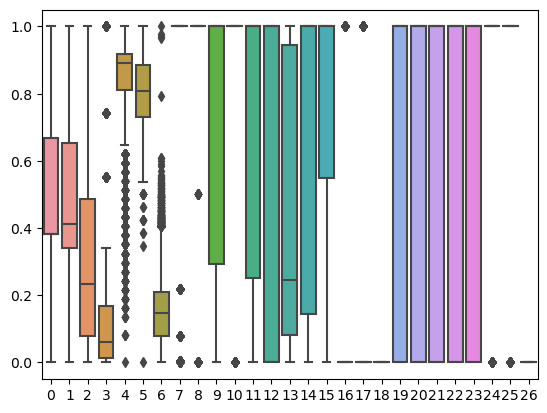

In [18]:
sns.boxplot(data = X_pp_scaled)

<AxesSubplot:>

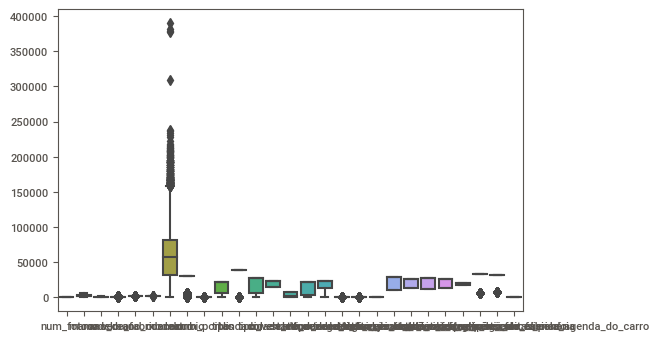

In [192]:
sns.boxplot(data=X_pp)

## Modelo com Count Encoder e StandardScaler
- Mean Absolute Error:     27672.902 +/- 243.071
- Root Mean Squared Error: 43435.920 +/- 1058.002

In [155]:
# Separando variável dependente de variáveis independentes
y = df['preco']
X = df.drop(columns=['ID', 'preco'])

# Train/Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Seleciona todas as features categóricas com exceção da feature 'ID'
cat_cols = df.select_dtypes(include=['object']).columns[1:]

# Encoder que substitui a categoria pelo número de vezes que ela aparece na feature.
# Nan é considerado uma categoria (com exceção da feature attr_veiculo_alienado que só tem Nan)
# cols: a list of columns to encode, if None, all string and categorical columns will be encoded.
te = CountEncoder(cols=cat_cols, return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
X_pp = te.fit_transform(X, y)

# A única feature que ainda possui Nan é attr_veiculo_alienado
X_pp = X_pp.fillna(0)

# xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
# xgb_tuned.fit(X_pp, y)

# Aplicando MinMaxScaler
scaler = StandardScaler()
X_pp_scaled = scaler.fit_transform(X_pp)

# Treinando Modelo
xgb = XGBRegressor(eval_metric='mae')
#xgb.fit(X_pp_scaled,y)

# Aplicando encoding no conjunto de teste
# X_test_pp = te.transform(X_test)
# X_test_pp = X_test_pp.fillna(0)

# Aplicando MinMaxScaler
# X_test_pp_scaled = scaler.transform(X_test_pp)

# Prevendo preços no conjunto de teste
# pred = xgb.predict(X_test_pp)

# Calculando MAE e RMSE
# print(f'MAE: {mean_absolute_error(pred, y_test)}')
# print(f'RMSE: {np.sqrt(mean_squared_error(pred,y_test))}')
evaluate(xgb, X_pp_scaled, y, cv=5)

# df_final = pd.concat([df_test[['ID']], pd.Series(pred, name='preco')], axis=1)
# df_final.head()

# df_final.to_csv('submission.csv', index=False) 

Mean Absolute Error:     27672.902 +/- 243.071
Root Mean Squared Error: 43435.920 +/- 1058.002


In [181]:
pd.DataFrame(X_pp_scaled, columns=X_pp.columns)

,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado
0,-0.635146,1.942859,0.559468,-0.563799,0.061660,-0.301706,-0.083284,0.555663,0.174568,-1.054171,0.090151,-1.367048,0.808353,1.250364,0.897682,0.746473,-0.501932,-0.452577,0.0,0.591189,0.737561,-1.490965,0.710107,0.925355,0.414687,-1.997816,0.0
1,-0.635146,-1.546823,-0.992101,-0.554896,0.061660,-0.301706,-0.323401,0.555663,0.174568,-1.301479,0.090151,0.637949,0.808353,1.117731,-1.145458,0.746473,-0.501932,-0.452577,0.0,0.591189,0.737561,-1.490965,0.710107,-1.080666,0.414687,-1.997816,0.0
2,1.049740,0.694862,0.313658,-0.285585,-1.162417,-1.796866,1.964846,0.555663,0.174568,0.891622,0.090151,-1.810112,-1.237083,1.117731,0.897682,-0.904455,1.992301,2.209569,0.0,0.591189,0.737561,0.670707,-1.408238,-1.080666,0.414687,0.500547,0.0
3,-0.635146,-1.394944,-1.030454,-0.617216,0.796106,1.193454,-1.357468,0.555663,-5.756529,-1.054171,0.090151,0.637949,0.808353,1.250364,0.897682,0.746473,-0.501932,-0.452577,0.0,0.591189,0.737561,-1.490965,-1.408238,-1.080666,0.414687,0.500547,0.0
4,-0.635146,-1.457932,-1.028711,-0.621667,-0.427971,-0.675496,-0.449329,0.555663,0.174568,-1.301479,0.090151,-1.367048,0.808353,-0.878981,0.897682,0.746473,-0.501932,-0.452577,0.0,0.591189,0.737561,-1.490965,-1.408238,-1.080666,0.414687,-1.997816,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39441,0.488111,1.942859,-0.763724,-0.523736,-0.427971,-1.049286,0.472392,-1.657723,0.174568,0.891622,0.090151,-1.810112,-1.237083,-0.991386,-1.364749,-0.904455,-0.501932,-0.452577,0.0,0.591189,-1.355821,0.670707,0.710107,0.925355,0.414687,0.500547,0.0
39442,1.892184,-0.273513,-0.999074,-0.514833,-0.183155,-0.301706,0.629234,0.555663,0.174568,-1.036075,0.090151,0.637949,-1.237083,-0.963935,0.897682,-0.904455,1.992301,2.209569,0.0,0.591189,0.737561,0.670707,-1.408238,-1.080666,0.414687,0.500547,0.0
39443,-0.635146,-0.349452,2.243531,3.424674,1.040922,1.567243,-1.493107,0.555663,0.174568,0.891622,0.090151,-1.827831,0.808353,1.250364,0.897682,0.746473,-0.501932,-0.452577,0.0,-1.691508,-1.355821,-1.490965,0.710107,0.925355,-2.411459,-1.997816,0.0
39444,1.330555,1.942859,0.559468,-0.603862,0.306475,0.445874,-0.208658,0.555663,0.174568,0.891622,0.090151,0.637949,-1.237083,-0.804140,0.897682,-2.571483,1.992301,-0.452577,0.0,0.591189,0.737561,0.670707,-1.408238,-1.080666,0.414687,0.500547,0.0


<AxesSubplot:>

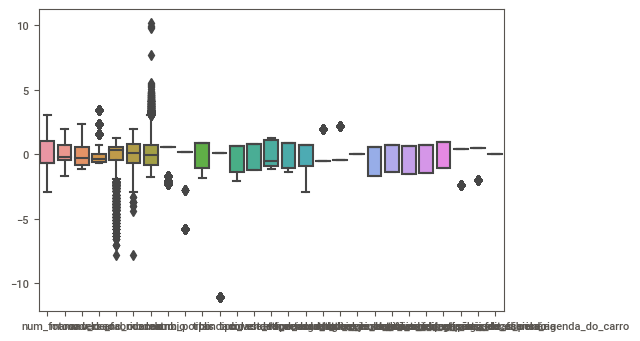

In [183]:
sns.boxplot(data=pd.DataFrame(X_pp_scaled, columns=X_pp.columns))

<AxesSubplot:>

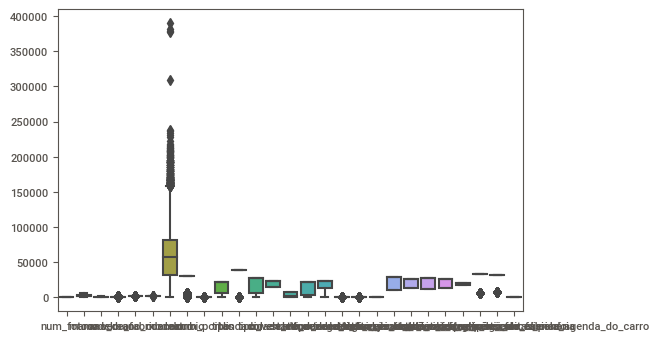

In [159]:
sns.boxplot(data=X_pp)

## Modelo com Count Encoder e coluna 'Versão' vetorizada
Evaluating the Model (6m47s)
- Mean Absolute Error:     26845.392 +/- 184.185
- Root Mean Squared Error: 42569.109 +/- 1619.545

Evaluating the tuned Model (1h23m) : xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
- Mean Absolute Error:     25797.958 +/- 235.092
- Root Mean Squared Error: 40978.808 +/- 1466.646

Modelo final utilizado no Hackday com log(preco). Ainda não avaliado aqui.
xgb_tuned4 = XGBRegressor(n_estimators= 3000, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.3, min_child_weight= 3)

Unindo a coluna 'Versão' com todas as outras colunas

In [34]:
X_complete = pd.concat([X_pp,df_versao], axis=1)

In [ ]:
# Separando variável dependente de variáveis independentes
y = df['preco']
X = df.drop(columns=['ID', 'preco'])

# Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Seleciona todas as features categóricas com exceção da feature 'ID'
cat_cols = df.select_dtypes(include=['object']).columns[1:]

# Encoder que substitui a categoria pelo número de vezes que ela aparece na feature.
# Nan é considerado uma categoria (com exceção da feature attr_veiculo_alienado que só tem Nan)
# cols: a list of columns to encode, if None, all string and categorical columns will be encoded.
# return_df: boolean for whether to return a pandas DataFrame from transform (otherwise it will be a numpy array).
te = CountEncoder(cols=cat_cols, return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
X_pp = te.fit_transform(X, y)

# A única feature que ainda possui Nan é attr_veiculo_alienado
X_pp = X_pp.fillna(0)

# Unindo a coluna 'versão' com todas as outras colunas
X_complete = pd.concat([X_pp,df_versao], axis=1)

# xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
# xgb_tuned.fit(X_pp, y)

# Treinando Modelo
xgb = XGBRegressor(eval_metric='mae')
# xgb.fit(X_pp,y)

# Aplicando encoding no conjunto de teste
# X_test_pp = te.transform(X_test)
# X_test_pp = X_test_pp.fillna(0)

# Prevendo preços no conjunto de teste
# pred = xgb.predict(X_test_pp)

# Calculando MAE e RMSE
# print(f'MAE: {mean_absolute_error(pred, y_test)}')
# print(f'RMSE: {np.sqrt(mean_squared_error(pred,y_test))}')
evaluate(xgb, X_complete, y, cv=5)

# df_final = pd.concat([df_test[['ID']], pd.Series(pred, name='preco')], axis=1)
# df_final.head()

# df_final.to_csv('submission.csv', index=False) 

In [43]:
# Avaliando o Modelo
xgb = XGBRegressor(eval_metric='mae')
evaluate(xgb, X_complete, y, cv=5)

Mean Absolute Error:     26845.392 +/- 184.185
Root Mean Squared Error: 42569.109 +/- 1619.545


In [44]:
xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
evaluate(xgb_tuned, X_complete, y, cv=5)

Mean Absolute Error:     25797.958 +/- 235.092
Root Mean Squared Error: 40978.808 +/- 1466.646


In [35]:
X_complete.shape

(39446, 724)

In [36]:
X_complete.head()

,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,10,100,104,10at,110,120,120cv,122cv,12v,130cv,131cv,140cv,142cv,143cv,150cv,155cv,16,164,16l,16v,170,170cv,180cv,182cv,183cv,184cv,18i,18l,18v,1a11,200,200cv,202cv,20i,20v,21,211cv,225cv,24v,25,250,2500,263,270,270cv,285cv,28i,2p,2ss,2wd,300,30d,30s13,30v,311,313,314,32v,330,340cv,35,350,35i,36v,3p,40,40v,415,416,45,4all,4d,4matic,4motion,4p,4s,4sport,4style,4wd,4x2,4x4,4you,50i,515,516,55,580,5m,60,6a,6i,6v,75,7g,7l,800kg,8v,90,94cv,97cv,9g,absolute,act,action,activ,activ7,active,activeflex,advance,advantage,adventure,air,all4,allgrip,allspace,allure,altis,alto,ambiente,ambition,amg,anos,at6,at8,at9,atacama,attack,attitude,attraction,attractive,audace,authentique,autobiography,automatico,automatizado,automático,automátizado,avant,avantgarde,awc,awd,b12p,base,be,bev,bi,biturbo,black,blackjack,bluehdi,bluemotion,bluetec,boost,bose,boxster,brabus,business,bva,cab,cabine,cabrio,cabriolet,cargo,cargo16v,carrera,cat,cayman,caçamba,cc,cd,cdi,ce,cgi,challenge,chassi,chassis,chic,chilli,cilindros,city,class,classic,clubman,colina,com,combinato,comfort,comfortline,compact,competition,confortline,connect,conquest,conversível,cooper,copa,country,coupe,coupé,coupê,crew,cross,crossover,crosstrek,crossway,crx,cs,cult,curl,curto,custom,cvt,d180,d240,d300,d5,dark,dci,dct,de,del,design,diamond,diesel,direct,dlx,do,drive,dsg,dx,dynamic,dynamique,eagle,easy,eat6,ecoboost,econo,economy,ecoshift,ecotec,edition,edição,edrive,efi,el,electric,electronic,elegance,elegant,eletronic,elevado,elite,elx,elétrico,endurance,enduro,engineered,eq,escapade,especial,essence,estate,ev,ev400,evidence,evo,evolution,ex,ex2,ex3,excellence,exclusive,executive,exl,experience,express,expression,exr,exs,extra,extreme,f1,fastback,feel,feline,fifa,fifty,fire,firefly,first,flex,flexone,flexstart,forest,freedom,freeride,freestyle,fsi,full,furgão,fwd,gas,gasolina,gdi,gear,geartronic,ghia,gl,gli,gls,glx,gp,gr,gran,grand,graphite,griffe,gsr,gsx,gt,gtdi,gte,gti,gts,guard,gx,h4,h6,hard,hatch,hd,hdi,hemi,hgt,hi,high,highline,highway,hl,hle,hls,hpe,hpi,hr,hse,hybrid,híbrido,i4,i6,iconic,ie,iflex,ii,iii,impetus,impress,in,ingenium,inscription,intense,intensive,intercoler,intercooler,iv,jet,jetflex,john,joy,k788,kinetic,kompressor,koup,kw,l1h1,l2h1,l2h2,l3h2,label,landmark,laramie,laredo,last,launch,launching,ldf,le,life,like,limitada,limited,line,lineartronic,live,locker,longitude,longo,look,lotação,lp,ls,lt,ltz,lugares,luxe,luxury,lx,lxl,lxr,lxs,m40i,m50d,m50i,mach,manual,max,maxicargo,maxx,mc,mct,mhev,mi,midnight,mille,million,minibus,mivec,moab,momentum,motion,motorsport,move,mpfi,mpi,msi,multiair,multidrive,multijet,multitronic,mundo,médio,night,ocean,open,origine,outdoor,outsider,overland,p250,p300,p380,p550,p8,pack,pallas,passion,pdk,pepper,performance,personal,phev,picasso,pick,platinum,plus,polestar,portfolio,power,powershift,precision,premier,premium,presence,prestige,prime,privilége,pro,progressive,pulse,pure,q4,quattro,raceshift,racing,ralliart,rallye,ranch,rbw,ready,rebel,recharge,rex,rigido,rio,rip,road,roadster,robust,rocam,rock,rs,rt,rts,run,rx,rxs,rxt,rígido,sahara,sce,sd4,sda,sdrive18i,sdrive20i,sdrive30i,sdv8,se,security,sedan,sel,selectshift,sem,sense,series,sfi,shadow,shift,shine,si,si4,sidi,sierra,sigma,sl,slt,smart,so,sol,spe4,spec,special,speed,speedshift,spider,spirit,sport,sport6,sportback,sporting,sportline,sportrac,sr,srv,srx,ss,start,std,steptronic,stepway,sti,storm,stradale,street,stx,style,super,supercharged,supersport,surf,sv,svautobiography,svr,sw,sx,sx3,sxt,série,t270,t3,t4,t5,t6,t8,ta,

In [42]:
df.preco

0        123231.992782
1        272076.023576
2         53411.539492
3        299697.071937
4        255164.344178
             ...      
39441    146046.941064
39442    106899.996631
39443    173246.622938
39444    221671.795447
39445    250577.070376
Name: preco, Length: 39446, dtype: float64

In [37]:
cat_cols

Index(['marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'],
      dtype='object')

In [30]:
X_pp.head()

,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado
0,8.0,6140,958,33,2017,2017.0,55672.0,30073,4,6426,39128,6985,23857,8198,21794,23949,False,False,False,29230,25548,12239,26223,21250,33658,7903,0.0
1,8.0,212,68,37,2017,2017.0,47858.0,30073,4,4458,39128,27919,23857,7739,2191,23949,False,False,False,29230,25548,12239,26223,18196,33658,7903,0.0
2,14.0,4020,817,158,2012,2013.0,122323.0,30073,4,21910,39128,2359,15589,7739,21794,13182,True,True,False,29230,25548,27207,13223,18196,33658,31543,0.0
3,8.0,470,46,9,2020,2021.0,14207.0,30073,2,6426,39128,27919,23857,8198,21794,23949,False,False,False,29230,25548,12239,13223,18196,33658,31543,0.0
4,8.0,363,47,7,2015,2016.0,43760.0,30073,4,4458,39128,6985,23857,829,21794,23949,False,False,False,29230,25548,12239,13223,18196,33658,7903,0.0


In [194]:
df.preco

0        123231.992782
1        272076.023576
2         53411.539492
3        299697.071937
4        255164.344178
             ...      
39441    146046.941064
39442    106899.996631
39443    173246.622938
39444    221671.795447
39445    250577.070376
Name: preco, Length: 39446, dtype: float64

In [29]:
df_23.preco

0        123231.992782
1        272076.023576
2         53411.539492
3        299697.071937
4        255164.344178
             ...      
39441    146046.941064
39442    106899.996631
39443    173246.622938
39444    221671.795447
39445    250577.070376
Name: preco, Length: 39446, dtype: float64

In [31]:
xgb = XGBRegressor(random_state=42)
xgb.fit(df_23.drop('preco',axis=1), df_23.preco)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:ID, marca, modelo, versao, cambio, tipo, blindado, cor, tipo_vendedor, cidade_vendedor, estado_vendedor, tipo_anuncio, attr_veiculo_aceita_troca, attr_veiculo_único_dono, attr_veiculo_todas_as_revisões_feitas_pela_concessionária, attr_veiculo_ipva_pago, attr_veiculo_licenciado, attr_veiculo_garantia_de_fábrica, attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39446 entries, 0 to 39445
Data columns (total 29 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   ID                                                          39446 non-null  object 
 1   num_fotos                                                   39209 non-null  float64
 2   marca                                                       39446 non-null  object 
 3   modelo                                                      39446 non-null  object 
 4   versao                                                      39446 non-null  object 
 5   ano_de_fabricacao                                           39446 non-null  int64  
 6   ano_modelo                                                  39446 non-null  float64
 7   odometro                                                    39446 non-null  float64
 

In [52]:
# list of numerical variables
num_cols = df.select_dtypes(include='number')
print('Number of numerical variables: ', len(num_cols))

# visualise the numerical variables
df[num_cols].head()

Number of numerical variables:  39446


ValueError: Boolean array expected for the condition, not object

In [50]:
num_cols = df.select_dtypes(include='number').columns

In [51]:
num_cols

Index(['num_fotos', 'ano_de_fabricacao', 'ano_modelo', 'odometro',
       'num_portas', 'attr_veiculo_alienado', 'preco'],
      dtype='object')

In [58]:
num_cols.columns[1:]

Index(['ano_de_fabricacao', 'ano_modelo', 'odometro', 'num_portas',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

In [59]:
df.select_dtypes(include=['object']).columns[1:]

Index(['marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'],
      dtype='object')

In [196]:
coun_vect = CountVectorizer()
count_matrix = coun_vect.fit_transform(df.versao)
count_array = count_matrix.toarray()

display(pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out()))

,10,100,104,10at,110,120,120cv,122cv,12v,130cv,131cv,140cv,142cv,143cv,150cv,155cv,16,164,16l,16v,170,170cv,180cv,182cv,183cv,184cv,18i,18l,18v,1a11,200,200cv,202cv,20i,20v,21,211cv,225cv,24v,25,250,2500,263,270,270cv,285cv,28i,2p,2ss,2wd,300,30d,30s13,30v,311,313,314,32v,330,340cv,35,350,35i,36v,3p,40,40v,415,416,45,4all,4d,4matic,4motion,4p,4s,4sport,4style,4wd,4x2,4x4,4you,50i,515,516,55,580,5m,60,6a,6i,6v,75,7g,7l,800kg,8v,90,94cv,97cv,9g,absolute,act,action,activ,activ7,active,activeflex,advance,advantage,adventure,air,all4,allgrip,allspace,allure,altis,alto,ambiente,ambition,amg,anos,at6,at8,at9,atacama,attack,attitude,attraction,attractive,audace,authentique,autobiography,automatico,automatizado,automático,automátizado,avant,avantgarde,awc,awd,b12p,base,be,bev,bi,biturbo,black,blackjack,bluehdi,bluemotion,bluetec,boost,bose,boxster,brabus,business,bva,cab,cabine,cabrio,cabriolet,cargo,cargo16v,carrera,cat,cayman,caçamba,cc,cd,cdi,ce,cgi,challenge,chassi,chassis,chic,chilli,cilindros,city,class,classic,clubman,colina,com,combinato,comfort,comfortline,compact,competition,confortline,connect,conquest,conversível,cooper,copa,country,coupe,coupé,coupê,crew,cross,crossover,crosstrek,crossway,crx,cs,cult,curl,curto,custom,cvt,d180,d240,d300,d5,dark,dci,dct,de,del,design,diamond,diesel,direct,dlx,do,drive,dsg,dx,dynamic,dynamique,eagle,easy,eat6,ecoboost,econo,economy,ecoshift,ecotec,edition,edição,edrive,efi,el,electric,electronic,elegance,elegant,eletronic,elevado,elite,elx,elétrico,endurance,enduro,engineered,eq,escapade,especial,essence,estate,ev,ev400,evidence,evo,evolution,ex,ex2,ex3,excellence,exclusive,executive,exl,experience,express,expression,exr,exs,extra,extreme,f1,fastback,feel,feline,fifa,fifty,fire,firefly,first,flex,flexone,flexstart,forest,freedom,freeride,freestyle,fsi,full,furgão,fwd,gas,gasolina,gdi,gear,geartronic,ghia,gl,gli,gls,glx,gp,gr,gran,grand,graphite,griffe,gsr,gsx,gt,gtdi,gte,gti,gts,guard,gx,h4,h6,hard,hatch,hd,hdi,hemi,hgt,hi,high,highline,highway,hl,hle,hls,hpe,hpi,hr,hse,hybrid,híbrido,i4,i6,iconic,ie,iflex,ii,iii,impetus,impress,in,ingenium,inscription,intense,intensive,intercoler,intercooler,iv,jet,jetflex,john,joy,k788,kinetic,kompressor,koup,kw,l1h1,l2h1,l2h2,l3h2,label,landmark,laramie,laredo,last,launch,launching,ldf,le,life,like,limitada,limited,line,lineartronic,live,locker,longitude,longo,look,lotação,lp,ls,lt,ltz,lugares,luxe,luxury,lx,lxl,lxr,lxs,m40i,m50d,m50i,mach,manual,max,maxicargo,maxx,mc,mct,mhev,mi,midnight,mille,million,minibus,mivec,moab,momentum,motion,motorsport,move,mpfi,mpi,msi,multiair,multidrive,multijet,multitronic,mundo,médio,night,ocean,open,origine,outdoor,outsider,overland,p250,p300,p380,p550,p8,pack,pallas,passion,pdk,pepper,performance,personal,phev,picasso,pick,platinum,plus,polestar,portfolio,power,powershift,precision,premier,premium,presence,prestige,prime,privilége,pro,progressive,pulse,pure,q4,quattro,raceshift,racing,ralliart,rallye,ranch,rbw,ready,rebel,recharge,rex,rigido,rio,rip,road,roadster,robust,rocam,rock,rs,rt,rts,run,rx,rxs,rxt,rígido,sahara,sce,sd4,sda,sdrive18i,sdrive20i,sdrive30i,sdv8,se,security,sedan,sel,selectshift,sem,sense,series,sfi,shadow,shift,shine,si,si4,sidi,sierra,sigma,sl,slt,smart,so,sol,spe4,spec,special,speed,speedshift,spider,spirit,sport,sport6,sportback,sporting,sportline,sportrac,sr,srv,srx,ss,start,std,steptronic,stepway,sti,storm,stradale,street,stx,style,super,supercharged,supersport,surf,sv,svautobiography,svr,sw,sx,sx3,sxt,série,t270,t3,t4,t5,t6,t8,ta,take,talent,targa,tce,tci,td,td350,td380,td4,td6,tdi,tdv6,tdv8,tech,tecno,tendance,teto,tetrafuel,tfsi,tgdi,tgv,thp,ti,tiptronic,titanium,top,tornado,torq,total,totalflex,touring,track,trailhawk,trekking,trend,trendline,tronic,trooper,tropical,tropivan,ts,tsi,turbo,turbocharged,turismo,tweed,twin,twinpower,twinturbo,txs,ue71,ultimate,ultra,unique,unlimited,up,upper,urban,v10,v6,v8,van,variant,vct,vhc,vhce,vi,vibe,vip,vision,vitré,vivace,volcano,vr4,vtc,vtec,vti,vvt,wa

## Modelo com Count Encoder, coluna 'Versão' vetorizada e log(preco)

In [45]:
# Separando variável dependente de variáveis independentes
y = df['preco']
X = df.drop(columns=['ID', 'preco'])

# Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Seleciona todas as features categóricas com exceção da feature 'ID'
cat_cols = df.select_dtypes(include=['object']).columns[1:]

# Encoder que substitui a categoria pelo número de vezes que ela aparece na feature.
# Nan é considerado uma categoria (com exceção da feature attr_veiculo_alienado que só tem Nan)
# cols: a list of columns to encode, if None, all string and categorical columns will be encoded.
# return_df: boolean for whether to return a pandas DataFrame from transform (otherwise it will be a numpy array).
te = CountEncoder(cols=cat_cols, return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
X_pp = te.fit_transform(X, y)

# A única feature que ainda possui Nan é attr_veiculo_alienado
X_pp = X_pp.fillna(0)

# Vetorização da coluna 'versao'
coun_vect = CountVectorizer()
text = df.versao
count_matrix = coun_vect.fit_transform(text)
count_array = count_matrix.toarray()
df_versao = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out())

# Unindo a coluna 'versão' com todas as outras colunas
X_complete = pd.concat([X_pp,df_versao], axis=1)

# xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
# xgb_tuned.fit(X_pp, y)

# Treinando Modelo
xgb = XGBRegressor(eval_metric='mae')
# xgb.fit(X_pp,y)

# Aplicando encoding no conjunto de teste
# X_test_pp = te.transform(X_test)
# X_test_pp = X_test_pp.fillna(0)

# Prevendo preços no conjunto de teste
# pred = xgb.predict(X_test_pp)

# Calculando MAE e RMSE
# print(f'MAE: {mean_absolute_error(pred, y_test)}')
# print(f'RMSE: {np.sqrt(mean_squared_error(pred,y_test))}')
evaluate(xgb, X_complete, np.log1p(y), cv=5) # transformação logarítmica no y

# df_final = pd.concat([df_test[['ID']], pd.Series(pred, name='preco')], axis=1)
# df_final.head()

# df_final.to_csv('submission.csv', index=False) 

Mean Absolute Error:     0.204 +/- 0.001
Root Mean Squared Error: 0.270 +/- 0.002


In [46]:
np.expm1(0.204)

0.2262981534562106

In [75]:
np.log1p(100000)

11.51293546492023

In [71]:
np.log1p(9/4)

1.1786549963416462

In [73]:
np.expm1(1.1786)

2.249821266804531

In [82]:
df.preco.mean()

133385.87434778194

In [80]:
df.preco.mean()*(np.expm1(0.204)-1)

-103200.89728573675

In [85]:
(df.preco.mean()+1)*np.expm1(0.204)

30185.203360198637

In [81]:
df.preco.mean()*np.expm1(0.204)

30184.97706204518

In [52]:
cv_results = cross_validate(
    xgb,
    X_complete,
    np.log1p(y),
    cv=5,
    scoring=["neg_mean_absolute_error"],
)

In [64]:
cv_results['test_neg_mean_absolute_error']

array([-0.20282348, -0.20413087, -0.20545874, -0.20340301, -0.20565287])

In [67]:
np.expm1(-cv_results['test_neg_mean_absolute_error'])

array([0.22485624, 0.22645865, 0.22808831, 0.22556629, 0.22832674])

In [47]:
xgb.fit(X_complete,np.log1p(y))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [50]:
y_pred_log = xgb.predict(X_complete)
y_pred = np.expm1(y_pred_log)

In [51]:
mean_absolute_error(y_pred,y)

23506.777155265587

In [83]:
y_pred

array([181914.16 , 255368.58 ,  46101.246, ..., 127019.02 , 138020.4  ,
       318000.16 ], dtype=float32)

In [84]:
y

0        123231.992782
1        272076.023576
2         53411.539492
3        299697.071937
4        255164.344178
             ...      
39441    146046.941064
39442    106899.996631
39443    173246.622938
39444    221671.795447
39445    250577.070376
Name: preco, Length: 39446, dtype: float64

### Submission with Default XGB
1m45s
- Public Score = 28154.28185
- Private Score = 27963.41998

In [102]:
df_test=df_test_raw

# Separando variável dependente de variáveis independentes
# y = df['preco']
X_test = df_test.drop(columns=['ID'])

# Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Seleciona todas as features categóricas com exceção da feature 'ID'
cat_cols = df_test.select_dtypes(include=['object']).columns[1:]

# Encoder que substitui a categoria pelo número de vezes que ela aparece na feature.
# Nan é considerado uma categoria (com exceção da feature attr_veiculo_alienado que só tem Nan)
# cols: a list of columns to encode, if None, all string and categorical columns will be encoded.
# return_df: boolean for whether to return a pandas DataFrame from transform (otherwise it will be a numpy array).
te = CountEncoder(cols=cat_cols, return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
te_fit = te.fit(X, y)
X_test_pp = te_fit.transform(X_test, y)

# A única feature que ainda possui Nan é attr_veiculo_alienado
X_test_pp = X_test_pp.fillna(0)

# Vetorização da coluna 'versao'
count_vect = CountVectorizer()
text_test = df_test.versao
count_vect_fit = count_vect.fit(df.versao)
count_matrix_test = count_vect_fit.transform(text_test)
count_array_test = count_matrix_test.toarray()
df_test_versao = pd.DataFrame(data=count_array_test,columns = count_vect.get_feature_names_out())

# Unindo a coluna 'versão' com todas as outras colunas
X_test_complete = pd.concat([X_test_pp,df_test_versao], axis=1)

# xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
# xgb_tuned.fit(X_pp, y)

# Treinando Modelo
xgb = XGBRegressor(eval_metric='mae')
xgb.fit(X_complete,np.log1p(y))

# Aplicando encoding no conjunto de teste
# X_test_pp = te.transform(X_test)
# X_test_pp = X_test_pp.fillna(0)

# Prevendo preços no conjunto de teste
pred_log = xgb.predict(X_test_complete)

# Calculando MAE e RMSE
# print(f'MAE: {mean_absolute_error(pred, y_test)}')
# print(f'RMSE: {np.sqrt(mean_squared_error(pred,y_test))}')
# evaluate(xgb, X_complete, np.log1p(y), cv=5) # transformação logarítmica no y

df_final = pd.concat([df_test[['ID']], pd.Series(np.expm1(pred_log), name='preco')], axis=1)
df_final.head()

df_final.to_csv('submission_ce_versao_log.csv', index=False) 

In [103]:
df_final.head()

,ID,preco
0,24813264385557040124808779273028388499,75508.351562
1,295636316453795508942188530111300065666,111438.570312
2,101258309166227950735244624080888109884,100526.015625
3,28348734455782469411126661985772047409,81846.148438
4,193163160502972147671913739170248305797,105795.929688


In [94]:
df_final.head()

,ID,preco
0,24813264385557040124808779273028388499,109674.976562
1,295636316453795508942188530111300065666,175663.156250
2,101258309166227950735244624080888109884,167676.468750
3,28348734455782469411126661985772047409,96389.500000
4,193163160502972147671913739170248305797,101617.046875


In [89]:
df_final.head()

,ID,preco
0,24813264385557040124808779273028388499,183607.265625
1,295636316453795508942188530111300065666,274956.468750
2,101258309166227950735244624080888109884,49518.093750
3,28348734455782469411126661985772047409,311380.937500
4,193163160502972147671913739170248305797,261250.265625


### Submission with Tuned Model
21m51s
- Private Score = 26644.97520
- Public Score =  26679.97509

In [105]:
df_test=df_test_raw

# Separando variável dependente de variáveis independentes
y = df['preco']
X = df.drop(columns=['ID', 'preco'])

# Separando variável dependente de variáveis independentes
# y = df['preco']
X_test = df_test.drop(columns=['ID'])

# Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Seleciona todas as features categóricas com exceção da feature 'ID'
cat_cols = df_test.select_dtypes(include=['object']).columns[1:]

# Encoder que substitui a categoria pelo número de vezes que ela aparece na feature.
# Nan é considerado uma categoria (com exceção da feature attr_veiculo_alienado que só tem Nan)
# cols: a list of columns to encode, if None, all string and categorical columns will be encoded.
# return_df: boolean for whether to return a pandas DataFrame from transform (otherwise it will be a numpy array).
te = CountEncoder(cols=cat_cols, return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
te_fit = te.fit(X, y)
X_test_pp = te_fit.transform(X_test, y)

# A única feature que ainda possui Nan é attr_veiculo_alienado
X_test_pp = X_test_pp.fillna(0)

# Vetorização da coluna 'versao'
count_vect = CountVectorizer()
text_test = df_test.versao
count_vect_fit = count_vect.fit(df.versao)
count_matrix_test = count_vect_fit.transform(text_test)
count_array_test = count_matrix_test.toarray()
df_test_versao = pd.DataFrame(data=count_array_test,columns = count_vect.get_feature_names_out())

# Unindo a coluna 'versão' com todas as outras colunas
X_test_complete = pd.concat([X_test_pp,df_test_versao], axis=1)

# xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
# xgb_tuned.fit(X_pp, y)

# Treinando Modelo
#xgb = XGBRegressor(eval_metric='mae')
xgb_tuned4 = XGBRegressor(n_estimators= 3000, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.3, min_child_weight= 3)
xgb_tuned4.fit(X_complete,np.log1p(y))

# Aplicando encoding no conjunto de teste
# X_test_pp = te.transform(X_test)
# X_test_pp = X_test_pp.fillna(0)

# Prevendo preços no conjunto de teste
pred_log = xgb_tuned4.predict(X_test_complete)

# Calculando MAE e RMSE
# print(f'MAE: {mean_absolute_error(pred, y_test)}')
# print(f'RMSE: {np.sqrt(mean_squared_error(pred,y_test))}')
# evaluate(xgb, X_complete, np.log1p(y), cv=5) # transformação logarítmica no y

df_final = pd.concat([df_test[['ID']], pd.Series(np.expm1(pred_log), name='preco')], axis=1)
df_final.head()

df_final.to_csv('submission_tuned4_ce_versao_log.csv', index=False) 

In [108]:
df_final.head()

,ID,preco
0,24813264385557040124808779273028388499,73822.726562
1,295636316453795508942188530111300065666,113483.921875
2,101258309166227950735244624080888109884,105376.539062
3,28348734455782469411126661985772047409,81874.484375
4,193163160502972147671913739170248305797,99120.226562


In [106]:
df_final.head()

,ID,preco
0,24813264385557040124808779273028388499,75508.351562
1,295636316453795508942188530111300065666,111438.570312
2,101258309166227950735244624080888109884,100526.015625
3,28348734455782469411126661985772047409,81846.148438
4,193163160502972147671913739170248305797,105795.929688


## Modelo com Count Encoder, SEM coluna 'Versão' vetorizada e log(preco)
Modelo com melhor performance na Competição
- Private Score = 25371.55316
- Public Score = 25324.45051

In [118]:
df_test=df_test_raw

# Separando variável dependente de variáveis independentes
y = df['preco']
X = df.drop(columns=['ID', 'preco'])

# Separando variável dependente de variáveis independentes
# y = df['preco']
X_test = df_test.drop(columns=['ID'])

# Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Seleciona todas as features categóricas com exceção da feature 'ID'
cat_cols = df_test.select_dtypes(include=['object']).columns[1:]

# Encoder que substitui a categoria pelo número de vezes que ela aparece na feature.
# Nan é considerado uma categoria (com exceção da feature attr_veiculo_alienado que só tem Nan)
# cols: a list of columns to encode, if None, all string and categorical columns will be encoded.
# return_df: boolean for whether to return a pandas DataFrame from transform (otherwise it will be a numpy array).
te = CountEncoder(cols=cat_cols, return_df=True)

# Dataframe X após encoding (não entendo a necessidade de colocar y_train como segundo argumento )
X_pp = te.fit_transform(X, y)
X_test_pp = te.transform(X_test)
#te_fit = te.fit(X, y)
#X_test_pp = te_fit.transform(X_test)

# A única feature que ainda possui Nan é attr_veiculo_alienado
X_test_pp = X_test_pp.fillna(0)

# xgb_tuned = XGBRegressor(n_estimators= 1700, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.5, min_child_weight= 3) 
# xgb_tuned.fit(X_pp, y)

# Treinando Modelo
#xgb = XGBRegressor(eval_metric='mae')
xgb_tuned4 = XGBRegressor(n_estimators= 3000, eta= 0.01, max_depth= 9, subsample= 0.5, colsample_bytree= 0.3, min_child_weight= 3)
xgb_tuned4.fit(X_pp,np.log1p(y))

# Prevendo preços no conjunto de teste
pred_log = xgb_tuned4.predict(X_test_pp)

# Calculando MAE e RMSE
# print(f'MAE: {mean_absolute_error(pred, y_test)}')
# print(f'RMSE: {np.sqrt(mean_squared_error(pred,y_test))}')
# evaluate(xgb, X_complete, np.log1p(y), cv=5) # transformação logarítmica no y

df_final = pd.concat([df_test[['ID']], pd.Series(np.expm1(pred_log), name='preco')], axis=1)
df_final.head()

df_final.to_csv('submission_tuned4_ce_log.csv', index=False) 

In [113]:
 df_final.head()

,ID,preco
0,24813264385557040124808779273028388499,101187.773438
1,295636316453795508942188530111300065666,118215.507812
2,101258309166227950735244624080888109884,98805.281250
3,28348734455782469411126661985772047409,108202.937500
4,193163160502972147671913739170248305797,92607.414062


## Feature Selection

In [129]:
text = ['This is the first document.','This document is the second document.','And this is the third one.', 'Is this the first document?']
coun_vect = CountVectorizer()
count_matrix = coun_vect.fit_transform(text)
count_array = count_matrix.toarray()

print(pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out()))

   and  document  first  is  one  second  the  third  this
0    0         1      1   1    0       0    1      0     1
1    0         2      0   1    0       1    1      0     1
2    1         0      0   1    1       0    1      1     1
3    0         1      1   1    0       0    1      0     1


In [128]:
text = ['This is the first document.','This document is the second document.','And this is the third one.', 'Is this the first document?']
coun_vect = CountVectorizer(max_features=3)
count_matrix = coun_vect.fit_transform(text)
count_array = count_matrix.toarray()

print(pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out()))


   document  is  the
0         1   1    1
1         2   1    1
2         0   1    1
3         1   1    1
